In [80]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from IPython.display import display

In [29]:
# Some rows contain commas in the word name and they are not quoted, so we need to process them carefully
with open('urbandict-word-defs.csv', 'r') as csvfile:
    lines = csvfile.readlines()
    lines = list(csv.reader(lines, delimiter=',', quotechar='"'))
    for i, line in enumerate(lines):
        if len(line) > 6:
            lines[i] = [line[0]] +  [','.join(line[1:-4])] + line[-4:]

In [113]:
df = pd.DataFrame(lines[1:], columns=lines[0])
# Setting correct data type on numeric columns, and correcting negative votes.
numeric_cols = ["up_votes", "down_votes"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric).apply(abs)
# We may also be interested in these variables
df['total_votes'] = df.up_votes + df.down_votes
df['up_ratio'] = df.up_votes / df.total_votes
display(df.head())
display(df.describe())

,word_id,word,up_votes,down_votes,author,definition,total_votes,up_ratio
0,0000007,Janky,296,255,dc397b2f,Undesirable; less-than optimum.,551,0.537205
1,0000008,slumpin',16,37,dc397b2f,"low down and funky, but [knee deep] enough to ...",53,0.301887
2,0000009,yayeeyay,19,27,dc397b2f,"affirmation; suggestion of encouragement, appr...",46,0.413043
3,0000012,hard-core,162,96,d1610749,anything out of our league that can be good or...,258,0.627907
4,0000013,brutal,12,45,40ece1ef,anything that makes you sweat,57,0.210526


,up_votes,down_votes,total_votes,up_ratio
count,2.580925e+06,2.580925e+06,2.580925e+06,2.447616e+06
mean,6.518014e+01,4.210493e+01,1.072851e+02,6.000241e-01
std,5.632438e+02,2.817211e+02,8.080962e+02,2.808843e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,5.000000e+00,3.951473e-01
50%,8.000000e+00,6.000000e+00,1.600000e+01,6.315789e-01
75%,2.800000e+01,2.300000e+01,5.400000e+01,8.181818e-01
max,2.890020e+05,1.003770e+05,3.705830e+05,1.000000e+00


## Let's do some exploratory work
First let's check the distribution of variables

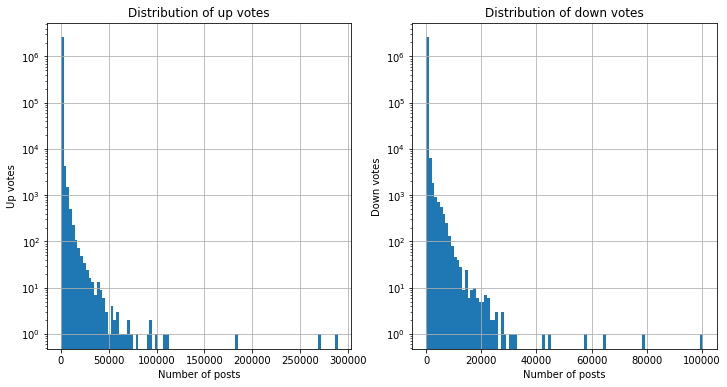

In [114]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
df.up_votes.hist(ax=axes[0], bins=100)
axes[0].set_yscale('log')
axes[0].set_ylabel('Up votes')
axes[0].set_xlabel('Number of posts')
axes[0].set_title('Distribution of up votes')
df.down_votes.hist(ax=axes[1], bins=100)
axes[1].set_yscale('log')
axes[1].set_ylabel('Down votes')
axes[1].set_xlabel('Number of posts')
axes[1].set_title('Distribution of down votes')
plt.show()

Faith in humanity restored: there are more upvotes than downvotes. 

Haters aren't hating that much.

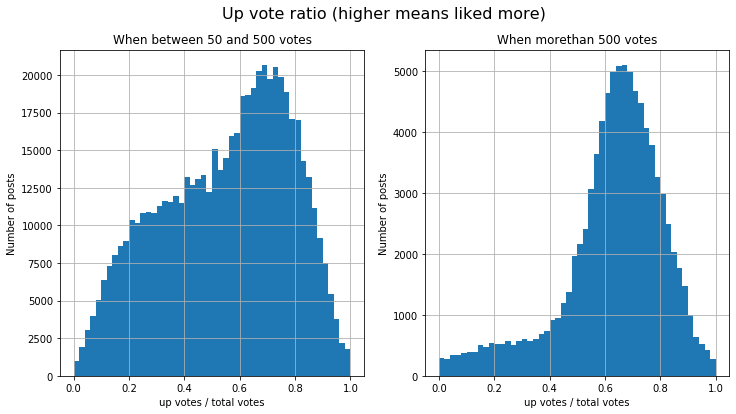

In [145]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
fig.suptitle('Up vote ratio (higher means liked more)', fontsize=16)

df.up_ratio[(df.total_votes > 50) & (df.total_votes < 500)].hist(ax=axes[0], bins=50)
axes[0].set_ylabel('Number of posts')
axes[0].set_xlabel('up votes / total votes')
axes[0].set_title('When between 50 and 500 votes')
df.up_ratio[df.total_votes > 500].hist(ax=axes[1], bins=50)
axes[1].set_ylabel('Number of posts')
axes[1].set_xlabel('up votes / total votes')
axes[1].set_title('When morethan 500 votes')
plt.show()

It seems that post that gather lots of votes are very likely to get lots of upvotes.

Authors with the largest number of posts:


a6c97ba3    16970
f668a9f4     1851
703f2483     1645
2438f900     1265
19de25da     1177
Name: author, dtype: int64


Stats on the post counts:


count    1.917941e+06
mean     1.345675e+00
std      1.304282e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.697000e+04
Name: author, dtype: float64

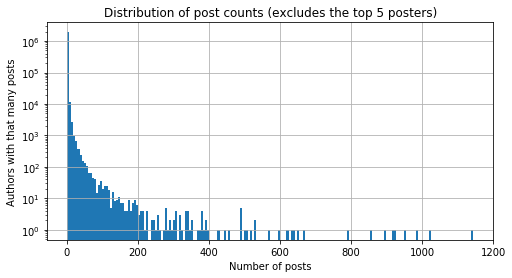

In [141]:
# Displaying info on post counts.
counts = df.author.value_counts()
print('Authors with the largest number of posts:')
display(counts.head())
print('')
print('Stats on the post counts:')
display(counts.describe())
fig, ax = plt.subplots(figsize=(8,4))
counts[5:].hist(ax=ax, bins=200)
ax.set_yscale('log')
ax.set_ylabel('Authors with that many posts')
ax.set_xlabel('Number of posts')
ax.set_title('Distribution of post counts (excludes the top 5 posters)')
plt.show()

## Machine Learning model

We first need to define how good the posts have to be to be considered in the ML model. Some models allow some weights that say how important is a particular sample. We could set the weights equal to the upvote ratio. But in addition, I think we should define the threshold at which we don't consider a case at all. 

Other questions we need to answer are:
* Should we use only a single answer to each word?
* Should we add the best answer for each word, even if it has poor reviews?
* Minimum number of total votes required?

In [182]:
# let's first check how many unique words after we select a threshold of minimum up votes.
min_votes = [5, 10, 20, 50, 100]
columns = ['no_min'] + [str(i) for i in min_votes]
unique_values = []
unique_values.append([len(df)] + [len(df[df.up_votes > i]) for i in min_votes])
unique_values.append([len(df.word_id.unique())] + [len(df[df.up_votes > i].word_id.unique()) for i in min_votes])
unique_values.append([len(df.word.unique())] + [len(df[df.up_votes > i].word.unique()) for i in min_votes])
display(pd.DataFrame(unique_values, columns=columns, index=['all', 'word_id', 'word']))

,no_min,5,10,20,50,100
all,2580925,1544871,1137044,779955,414148,233342
word_id,2580925,1544871,1137044,779955,414148,233342
word,1743283,928184,643278,420454,209768,115441


It seems that `word_id` is unique for each entry, and that most words have a single definition.

When we increase the threshold, the number of unique words falls considerably. It may be better to keep it to 5 or 10.

In [183]:
# setting the min upvote threshold and getting the post with highest upvote ratio
fdf = df[df.up_votes > 5].sort_values('up_ratio').groupby('word').last().reset_index()
# Removing whitespace words
fdf[fdf.word.str.strip() != '']

,word,word_id,up_votes,down_votes,author,definition,total_votes,up_ratio
4,))),6054218,7,4,8a544a6c,"uber wink. like a wink, but to the third power...",11,0.636364
5,l @(^.^)@ l,2420836,8,40,ef17dafc,"rockin to something, listening to a really awe...",48,0.166667
6,!,1740131,12,13,82003752,Flip you off or inother words fuck off bitches,25,0.480000
7,! (-.-) !,1462931,30,14,6cb87e2f,e-flipping someone off.,44,0.681818
8,),2740340,59,26,a846df0c,a sideways wink you type when you flirt,85,0.694118
...,...,...,...,...,...,...,...,...
928179,~whore,1925472,8,0,b9ae653c,The tildle or ~ represents a word that can be ...,8,1.000000
928180,~{ (o_o) }~,3681553,11,1,48b6b23b,Awkward turtle. this is a mascot to when somet...,12,0.916667
928181,~~,1016796,26,16,95a957f4,"Cynical, rolling of the eyes. Expressed often ...",42,0.619048
928182,~~~lol~~~,5801339,10,5,21ef316,~~~lol~~~ it looks like a man drowning :L ;; I...,15,0.666667


In [188]:
# let's make sure we actually have one definition per word
print(len(fdf) == len(fdf.word.unique()))

True


## Actually making the model now